# Introduction

This notebooks presents **LSTM** trained to perform sentiment prediction on **Kindle Book Reviews**

**Dataset**

* [Amazon Review Data](http://jmcauley.ucsd.edu/data/amazon/) - download Kindle Store [5-core](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Kindle_Store_5.json.gz) file and extract

# Imports

In [1]:
import re
import time
import json
import collections
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load Data

Dataset location

In [4]:
dataset_location = '/home/marcin/Datasets/kindle-reviews/reviews_Kindle_Store_5.json'

Each line in data file is a separate JSON entry

In [5]:
with open(dataset_location, 'r') as f:
    line_raw = f.readline()
line_raw

'{"reviewerID": "A1F6404F1VG29J", "asin": "B000F83SZQ", "reviewerName": "Avidreader", "helpful": [0, 0], "reviewText": "I enjoy vintage books and movies so I enjoyed reading this book.  The plot was unusual.  Don\'t think killing someone in self-defense but leaving the scene and the body without notifying the police or hitting someone in the jaw to knock them out would wash today.Still it was a good read for me.", "overall": 5.0, "summary": "Nice vintage story", "unixReviewTime": 1399248000, "reviewTime": "05 5, 2014"}\n'

Lets print sample data item

In [6]:
line_json = json.loads(line_raw)
sample_score = line_json['overall']
sample_summary = line_json['summary']
sample_review = line_json['reviewText']
print('score:', sample_score)
print('summary:', sample_summary)
print('review:')
print(sample_review)

score: 5.0
summary: Nice vintage story
review:
I enjoy vintage books and movies so I enjoyed reading this book.  The plot was unusual.  Don't think killing someone in self-defense but leaving the scene and the body without notifying the police or hitting someone in the jaw to knock them out would wash today.Still it was a good read for me.


We need to clean it up by:
* removing punctuation, digits etc.
* convert to lower case
* split into words

In [7]:
regex = re.compile('[^a-zA-Z ]+')

def cleanup(text):
    res = regex.sub(' ', text)
    res = res.lower()
    return res.split()

print(cleanup(sample_review))

['i', 'enjoy', 'vintage', 'books', 'and', 'movies', 'so', 'i', 'enjoyed', 'reading', 'this', 'book', 'the', 'plot', 'was', 'unusual', 'don', 't', 'think', 'killing', 'someone', 'in', 'self', 'defense', 'but', 'leaving', 'the', 'scene', 'and', 'the', 'body', 'without', 'notifying', 'the', 'police', 'or', 'hitting', 'someone', 'in', 'the', 'jaw', 'to', 'knock', 'them', 'out', 'would', 'wash', 'today', 'still', 'it', 'was', 'a', 'good', 'read', 'for', 'me']


Lets load the whole dataset

In [8]:
reviews = []
summaries = []
scores = []
print('|' + ' '*48 + '|')
with open(dataset_location, 'r') as f:
    for i, l in enumerate(f):
        jl = json.loads(l)
        reviews.append(cleanup(jl['reviewText']))
        summaries.append(cleanup(jl['summary']))
        scores.append(int(jl['overall']))
        if i % 20000 == 0:
            print('.', end='')

|                                                |
..................................................

And lets have a look at few samples

In [9]:
def print_sample(idx):
    print('score:', scores[idx])
    print('summary:', ' '.join(summaries[idx]))
    print('review:')
    print(' '.join(reviews[idx]))

In [10]:
for i in range(3):
    print_sample(i)
    print()

score: 5
summary: nice vintage story
review:
i enjoy vintage books and movies so i enjoyed reading this book the plot was unusual don t think killing someone in self defense but leaving the scene and the body without notifying the police or hitting someone in the jaw to knock them out would wash today still it was a good read for me

score: 4
summary: different
review:
this book is a reissue of an old one the author was born in it s of the era of say nero wolfe the introduction was quite interesting explaining who the author was and why he s been forgotten i d never heard of him the language is a little dated at times like calling a gun a heater i also made good use of my fire s dictionary to look up words like deshabille and canarsie still it was well worth a look see

score: 4
summary: oldie
review:
this was a fairly interesting read it had old style terminology i was glad to get to read a story that doesn t have coarse crasslanguage i read for fun and relaxation i like the free eboo

Dataset is cleaned now, it contains only lowercase letters and spaces

# Preprocess Data

First we will count all the different words

In [11]:
words_counter = collections.Counter()
for review in reviews:
    words_counter.update(review)

In [12]:
print('Total words: ', sum(list(words_counter.values())))
print('Unique words:', len(words_counter))

Total words:  111201964
Unique words: 270677


Some of the words and their number of occurrences in whole dataset

In [13]:
print('WORD    : COUNT')
for w in list(words_counter)[:10]:
    print(f'{w:8}: {words_counter[w]}')

WORD    : COUNT
i       : 3117051
enjoy   : 72405
vintage : 394
books   : 245937
and     : 3583503
movies  : 3701
so      : 493257
enjoyed : 146518
reading : 225740
this    : 1738403


Lets plot word-counts on linear and logarithmic scales

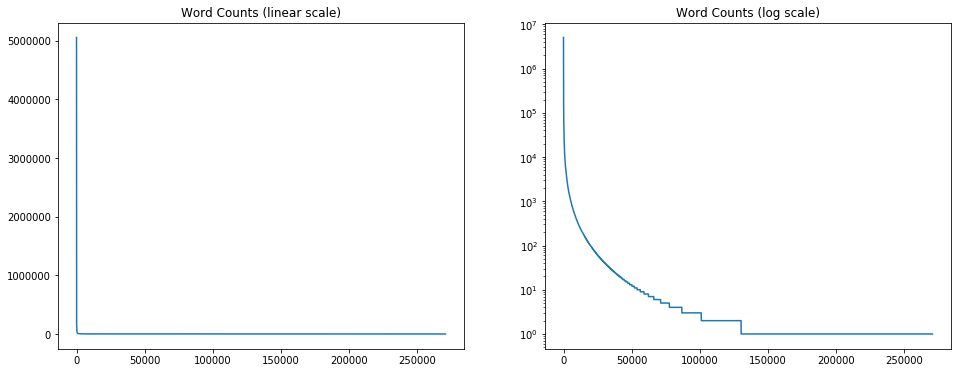

In [14]:
def plot_counts(words_counter):
    sorted_all = np.array(sorted(list(words_counter.values()), reverse=True))
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[16,6])
    ax1.plot(sorted_all); ax1.set_title('Word Counts (linear scale)')
    ax2.plot(sorted_all); ax2.set_title('Word Counts (log scale)')
    ax2.set_yscale('log')
    
plot_counts(words_counter)

This is extremely sharp distribution. Some words appear over 5 million times, while over 100k words appear only once.

**Common Words**

Lets have a look at the most common words.

In [15]:
words_counter.most_common()[:10]

[('the', 5056842),
 ('and', 3583503),
 ('to', 3120917),
 ('i', 3117051),
 ('a', 2999778),
 ('of', 2141725),
 ('is', 1780140),
 ('it', 1740139),
 ('this', 1738403),
 ('in', 1511066)]

Words like 'the', 'and', 'to' etc. don't contribute much to text meaning. They are called _stopwords_. Below is the list of stopwords in English language taken from NLTK library. This set was created with:

```python
import nltk
nltk.download('stopwords')
en_stopwords = nltk.corpus.stopwords.words('english')
stopwords = {sw for sw in en_stopwords}
print(stopwords)
```

I'm just copy-pasting it here not to introduce unnecessary `nltk` dependency.

In [16]:
# this list was aquired with:
# import nltk
# nltk.download('stopwords')
# print(stopwords.words('english'))
stopwords = {'down', 'then', 'of', 'but', 'only', 'yours', 'himself', 'again',
             'very', 'or', 'once', 'until', 'have', "doesn't", 'what', 'during',
             "that'll", 'some', 'was', 'be', 'he', "should've", 'between',
             "shouldn't", 'further', 'no', 'yourself', 'm', 've', "you'll",
             'ain', 't', 'our', 'his', 'o', 'wouldn', 'below', 'any', 'under',
             'you', 'isn', 'theirs', 'why', 'that', 'mightn', 'ourselves', 'on',
             'haven', 'while', 'to', 'than', 'your', 'she', 'is', 'just',
             "mightn't", 'with', "you've", 'mustn', 'needn', 'same', 'me',
             'such', 'myself', 'there', 'own', 'this', 're', 'ma', 'from',
             'did', 'couldn', 'hasn', 'for', 'won', "won't", "mustn't", 'her',
             'can', 'doesn', "wouldn't", 'when', "you're", 'who', 'which', 'll',
             'itself', 'against', 'out', 'up', "it's", 'a', 'here', 'being',
             'they', 'as', 'didn', 'weren', 'aren', 'herself', 'the', 'if',
             "didn't", 'should', 'doing', 'other', 'has', 'so', "you'd",
             'above', 'do', 'before', 'at', 'had', 'each', "aren't", 'their',
             'now', 'an', 'through', 'how', 'those', 'nor', "hasn't", 'over',
             'by', 'into', 'themselves', 'most', 'shan', 'been', "she's",
             "haven't", "isn't", "wasn't", 'where', 'about', 'in', "hadn't",
             'because', 'too', 'whom', 'ours', 'him', 'yourselves', 'after',
             'and', 'were', 'both', 'will', 'it', 'my', 'few', 'having', 'them',
             'hadn', 'shouldn', 'does', 's', "couldn't", 'y', 'all', 'don',
             'off', 'more', 'am', 'd', 'hers', 'its', 'are', "shan't",
             "weren't", 'we', "needn't", 'i', 'these', "don't", 'wasn', 'not'}

Remove stopwords

In [17]:
reviews_no_stop = []

print('|' + ' '*48 + '|')
for i in range(len(reviews)):
    reviews_no_stop.append( [w for w in reviews[i] if w not in stopwords] )
    if i % 20000 == 0:
        print('.', end='')

|                                                |
..................................................

In [20]:
words_counter = collections.Counter()
for review in reviews_no_stop:
    words_counter.update(review)

In [21]:
print('Total words: ', sum(list(words_counter.values())))
print('Unique words:', len(words_counter))

Total words:  53101559
Unique words: 270524


**Rare Words**

Lets look at some of of the uncommon words

In [22]:
words_counter.most_common()[-10:]

[('somethingthatisdoneveryquickly', 1),
 ('ofsexualintercoursethatisdonein', 1),
 ('averyshort', 1),
 ('amountoftimeanticipation', 1),
 ('afeelingofexcitementaboutsomethingthatisgoingto', 1),
 ('ofpreparingforsomething', 1),
 ('fieldingit', 1),
 ('chenell', 1),
 ('waitign', 1),
 ('uunderstand', 1)]

In [23]:
reviews_clean = []

print('|' + ' '*48 + '|')
for i in range(len(reviews)):
    reviews_clean.append( [w for w in reviews_no_stop[i] if words_counter[w] > 5] )
    if i % 20000 == 0:
        print('.', end='')

|                                                |
..................................................

In [24]:
words_counter = collections.Counter()
for review in reviews_clean:
    words_counter.update(review)

In [25]:
print('Total words: ', sum(list(words_counter.values())))
print('Unique words:', len(words_counter))

Total words:  52791345
Unique words: 71081


**Create dictionaries**

In [26]:
i2w = {i : w for i, (w, c) in enumerate(words_counter.most_common(), 1) if c > 5}
w2i = {w : i for i, w in i2w.items()}
i2w[0] = '<pad>'                       # use zero index for padding
w2i[i2w[0]] = 0
print('Number of words after filter:', len(i2w))

Number of words after filter: 71082


Confirm dictionaries are correct

In [27]:
for i in range(10):
    word = i2w[i]
    print(i, ':', word, ':', w2i[word])

0 : <pad> : 0
1 : book : 1
2 : story : 2
3 : read : 3
4 : one : 4
5 : love : 5
6 : like : 6
7 : really : 7
8 : good : 8
9 : characters : 9


**Tokenize Dataset**

In [28]:
reviews_tok = []

print('|' + ' '*48 + '|')
for i in range(len(reviews_clean)):
    reviews_tok.append( [w2i[w] for w in reviews_clean[i]] )
    if i % 20000 == 0:
        print('.', end='')

|                                                |
..................................................

In [35]:
print(reviews_clean[2])

['fairly', 'interesting', 'read', 'old', 'style', 'terminology', 'glad', 'get', 'read', 'story', 'coarse', 'read', 'fun', 'relaxation', 'like', 'free', 'check', 'writer', 'decide', 'intriguing', 'innovative', 'enough', 'command', 'convey', 'story', 'without', 'crude', 'language']


In [36]:
print(reviews_tok[2])

[1048, 81, 3, 153, 275, 7187, 232, 15, 3, 2, 12357, 3, 85, 8164, 6, 166, 593, 318, 892, 613, 7577, 92, 4105, 4843, 2, 133, 4851, 662]


**Trimming and Padding**

Lets have a look at review lengths next

In [37]:
lengths = np.array([len(r) for r in reviews_tok])
lenghts_counter = collections.Counter(lengths)

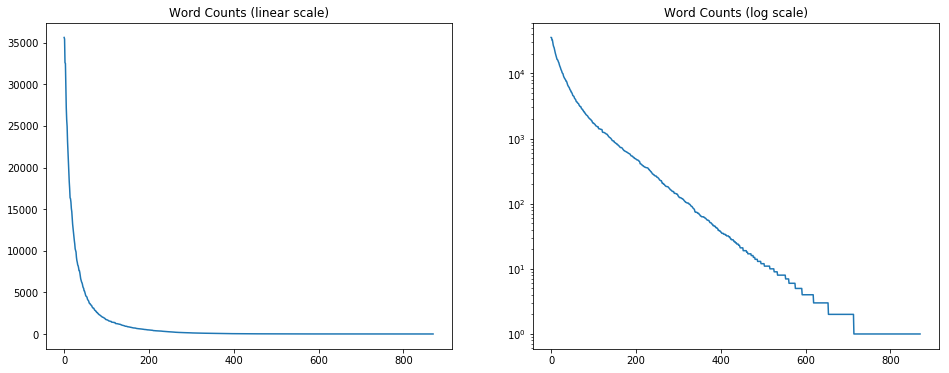

In [38]:
plot_counts(lenghts_counter)

We can see some reviews are over 35k words!

To feed reviews into neural network in mini-batches all reviews have to have same length.

We will:
* trim all reviews to 200 words
* pad all shorter reviews with <nop>

In [75]:
target_len = 200
reviews_np = np.zeros(shape=(len(reviews_tok), target_len), dtype=int)

for i in range(len(reviews_tok)):
    rev_trimmed = reviews_tok[i][:200]                # trim to 200
    start = target_len - len(rev_trimmed)
    reviews_np[i, start:target_len] = rev_trimmed

In [77]:
print(reviews_np)

[[   0    0    0 ...   56    8    3]
 [   0    0    0 ...  165  118   26]
 [   0    0    0 ...  133 4851  662]
 ...
 [   0    0    0 ...  111   69   31]
 [   0    0    0 ...    5   42   69]
 [   0    0    0 ... 3339  337   69]]


Check out the result

In [78]:
print(reviews_np[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

And convert back to string to make sure it's ok

In [79]:
' '.join(i2w[c] for c in reviews_np[0] if c != 0)

'enjoy vintage books movies enjoyed reading book plot unusual think killing someone self defense leaving scene body without notifying police hitting someone jaw knock would wash today still good read'

**Convert Labels**

Lets just check class distribution before we do anything

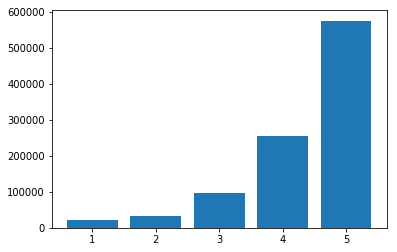

In [111]:
scores_counter = collections.Counter(scores)
plt.bar(scores_counter.keys(), scores_counter.values())
plt.plot();

Ok, this is not very well balanced dataset :S. There is not much we can do about it here

In [112]:
s2s = {1:0, 2:0, 3:1, 4:2, 5:2 }        # convert scores to 3-way scale neg/mix/pos
scores_np = np.array([s2s[s] for s in scores])
assert len(reviews_np) == len(scores_np)

Sanity check

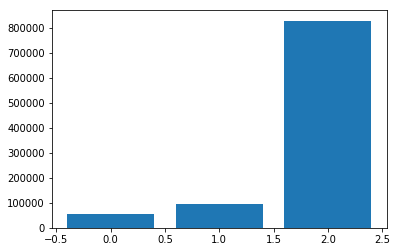

In [118]:
scores_counter = collections.Counter(scores_np)
plt.bar(scores_counter.keys(), scores_counter.values())
plt.plot();

**Shuffle and Split**

Create index array and shuffle

In [120]:
indices = np.array(range(len(reviews_np)))
np.random.shuffle(indices)

Calculate split points and split

In [121]:
train_split_index = int(len(reviews_np) * .90)
valid_split_index = int(len(reviews_np) * .95)

train_i, valid_i, test_i = np.split(
    indices, [train_split_index, valid_split_index])

print('Nb train reviews:', len(train_i))
print('Nb valid reviews: ', len(valid_i))
print('Nb test reviews:  ', len(test_i))

Nb train reviews: 884357
Nb valid reviews:  49131
Nb test reviews:   49131


Split the dataset into three parts

In [122]:
train_x, train_y = reviews_np[train_i], scores_np[train_i]
valid_x, valid_y = reviews_np[valid_i], scores_np[valid_i]
test_x, test_y = reviews_np[test_i], scores_np[test_i]

In [123]:
train_x = torch.tensor(train_x, device=device)
train_y = torch.tensor(train_y, device=device)
valid_x = torch.tensor(valid_x, device=device)
valid_y = torch.tensor(valid_y, device=device)

# Train Model

In [370]:
class SentimentNetwork(nn.Module):
    def __init__(self, nb_layers, n_vocab, n_embed, n_hid, n_out, dropout):
        super(SentimentNetwork, self).__init__()
        
        self.embed = nn.Embedding(num_embeddings=n_vocab, embedding_dim=n_embed)
        self.lstm = nn.LSTM(input_size=n_embed, hidden_size=n_hid, num_layers=nb_layers,
                           batch_first=True, dropout=dropout)
        self.drop = nn.Dropout(p=dropout)
        self.fc = nn.Linear(in_features=n_hid, out_features=n_out)
        
    def forward(self, x):
        x = self.embed(x)                   # shape [n_batch, n_seq, n_embed]
        x, _ = self.lstm(x)                 # shape [n_batch, n_seq, n_hid]
        x = x[:, -1, :]                     # shape [n_batch, n_hid]
        return self.fc(x)                   # shape [n_batch, n_out]
    
#     def init_hidden(self, n_batch):
#         x = torch.zeros(n_batch, 1, dtype=torch.int64, device=device)
#         x = self.embed(x)
#         _, self.hidden = self.lstm(x)

In [375]:
nb_layers = 2
n_vocab = len(i2w)
n_embed = 300
n_hid = 512
n_out = 3              # neg/mix/pos
n_batch = 256

In [376]:
model = SentimentNetwork(nb_layers, n_vocab, n_embed, n_hid, n_out, dropout=.5)
model.to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [ ]:
def accuracy(logits, labels): 
    predictions = torch.argmax(logits, dim=1)
    return (predictions == labels).float().mean()  # tensor!!

In [ ]:
def per_class_accuracy(y_true, y_pred, nb_classes):
    
    y_correct = y_true == y_hat
    result = torch.zeros(nb_classes)
    for c in range(nb_classes):
        curr_class =  y_true == c
        class_correct = y_true[curr_class] == y_hat[curr_class]
        class_acc = class_correct.sum(dtype=torch.float) / len(class_correct)
        result[c] = class_acc
        
    return result.cpu().numpy()

In [428]:
def evaluate(data_x, data_y):
    
    pred_y = torch.zeros_like(data_y) + 7  # model outputs
    
    model.eval()
    loss_sum, acc_sum = 0, 0
    with torch.no_grad():        
        for i in range(0, len(data_x), n_batch):

            # Pick mini-batch
            inputs = data_x[i:i+n_batch]
            targets = data_y[i:i+n_batch]

            # Forward pass
            outputs = model(inputs)                      # logits
            loss = criterion(outputs, targets)
            acc = accuracy(outputs, targets)

            pred_y[i:i+n_batch] = outputs.argmax(dim=1)  # logits
            
            # Record per-iteration loss
            loss_sum += loss.item() * len(inputs)
            acc_sum += acc.item() * len(inputs)
            
        nb_classes = outputs.shape[1]
        class_acc = per_class_accuracy(data_y, pred_y, nb_classes)

    loss_avg = loss_sum / len(data_x)
    acc_avg = acc_sum / len(data_x)
    
    return loss_avg, acc_avg, class_acc

In [377]:
trace = {'epoch': [], 'tloss': [], 'vloss': []}    # per epoch
trace2 = {'loss' : []}                             # per iteration

nb_epochs = 1

In [378]:
#def train(nb_epochs, trace, trace2):
if True:

    epoch = len(trace['epoch'])

    for _ in range(nb_epochs):

        time_start = time.time()

        #
        #   Train Model
        #
        model.train()
        tloss_sum = 0
        hidden = None                                  # reset LSTM hidden state
        for i in range(0, len(train_x), n_batch):

            # Pick mini-batch
            inputs = train_x[i:i+n_batch]    # [n_batch, n_seq], less for last batch
            targets = train_y[i:i+n_batch]   # [n_batch, n_seq], less for last batch
            
            # Optimize
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                acc = accuracy(outputs, targets)
                tloss_sum += loss.item() * len(inputs)
                tacc_sum  += acc.item() * len(inputs)
                
            
            if i % (100*n_batch) == 0:
                percent_complete = i * 100 / len(train_x)
                time_delta = time.time() - time_start
                print(f'Epoch: {epoch:3} ({percent_complete:.0f}%)     '
                      f'Loss: {loss:.4f}     Time: {time_delta:.2f}s')
                
                loss, acc, class_acc = evaluate(valid_x, valid_y)


#         tloss_avg = tloss_sum / train_size

#         #
#         #   Evaluate Model
#         #
#         model.eval()
#         vloss_sum = 0
#         hidden = None
#         with torch.no_grad():        
#             for i in range(0, valid_size, n_seq):

#                 # Pick mini-batch
#                 inputs = valid_x[:,i:i+n_seq]
#                 targets = valid_x[:,i+1:i+1+n_seq]
#                 if inputs.shape[1] != targets.shape[1]:
#                     inputs = inputs[:,:-1]

#                 # Optimize
#                 outputs, hidden = model(inputs, hidden)
#                 loss = criterion(outputs.view(-1, n_out), targets.flatten())

#                 # Record per-iteration loss
#                 vloss_sum += loss.item() * inputs.shape[1]

#         vloss_avg = vloss_sum / valid_size

        #
        #   Logging
        #

#         time_delta = time.time() - time_start

#         trace['epoch'].append(epoch)
#         trace['tloss'].append(tloss_avg)
#         trace['vloss'].append(vloss_avg)
        
#         #
#         #   Print loss
#         #
#         print(f'Epoch: {epoch:3}     '
#               f'T/V Loss: {tloss_avg:.4f} / {vloss_avg:.4f}     '
#               f'Time: {time_delta:.2f}s')

#         epoch += 1

Epoch:   0 (0%)     Loss: 1.1156     Time: 0.31s
Epoch:   0 (3%)     Loss: 0.3986     Time: 31.63s
Epoch:   0 (6%)     Loss: 0.3837     Time: 65.80s


KeyboardInterrupt: 

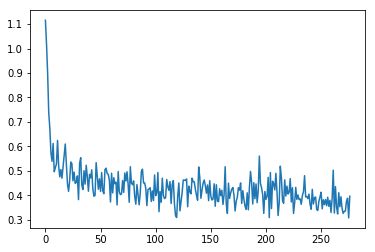

In [380]:
plt.plot(trace2['loss'])

In [ ]:
#         model.eval()
#         vloss_sum = 0
#         hidden = None
#         with torch.no_grad():        
#             for i in range(0, valid_size, n_seq):

#                 # Pick mini-batch
#                 inputs = valid_x[:,i:i+n_seq]
#                 targets = valid_x[:,i+1:i+1+n_seq]
#                 if inputs.shape[1] != targets.shape[1]:
#                     inputs = inputs[:,:-1]

#                 # Optimize
#                 outputs, hidden = model(inputs, hidden)
#                 loss = criterion(outputs.view(-1, n_out), targets.flatten())

#                 # Record per-iteration loss
#                 vloss_sum += loss.item() * inputs.shape[1]

#         vloss_avg = vloss_sum / valid_size


In [429]:
loss, acc, class_acc = evaluate(valid_x, valid_y)
print(loss, acc, class_acc)

0.3813960278067694 0.8655024321370272 [0.3570695  0.20452604 0.9758224 ]


In [416]:
per_class_accuracy(valid_y, predictions, nb_classes=3)

array([0.3570695 , 0.20452604, 0.9758224 ], dtype=float32)

In [408]:
y_true = valid_y
y_hat = predictions
nb_classes = 3


In [409]:
result

tensor([0.3571, 0.2045, 0.9758])

In [391]:
sum(y_correct)

tensor(27, device='cuda:0', dtype=torch.uint8)

In [396]:
result

tensor([0., 2., 1.])

tensor(1043., device='cuda:0')

In [392]:
y_hat = predictions.cpu().numpy()
y_true = valid_y.cpu().numpy()
get_class_coverage(y_true, y_hat, 3)

array([0.3570695 , 0.20452605, 0.97582238])

In [242]:
def plot_class_coverage(y, y_hat, axis=None):
    #
    #   Per-class accuracy
    #
    assert y.ndim == 2 and y_hat.ndim == 2
    assert y.shape == y_hat.shape
    
    nb_classses = y.shape[-1]
    
    y_correct = np.argmax(y, axis=-1) == np.argmax(y_hat, axis=-1)
    classes_correct = []
    classes_all = []
    for i in range(nb_classses):
        is_y_class_i = y_correct * (np.argmax(y, axis=-1)==i)
        nb_correct_class_i = np.sum(is_y_class_i)
        classes_correct.append(nb_correct_class_i)
        classes_all.append(np.count_nonzero(np.argmax(y, axis=-1)==i))
    classes_correct = np.array(classes_correct)
    classes_all = np.array(classes_all)

    if axis is None:
        fig, axis = plt.subplots()
    
    axis.bar(range(10), classes_all, label='All Member')
    axis.bar(range(10), classes_correct, label='Correctly Predicted')
    axis.legend(loc=3)

In [243]:
plot_class_coverage(y_true, y_hat)

AssertionError: 

In [222]:
loss_avg, acc_avg = evaluate(train_x, train_y)
print(loss_avg, acc_avg)

0.2872463878780543 0.89192034439275


In [229]:
outputs.argmax(dim=1)

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 1, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 0, 2,
        2, 2, 1, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 1, 2, 2,
        0, 2, 2, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
        2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        0, 2, 2, 2, 1, 2, 2, 2, 1, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2,

In [209]:
loss.item()

0.2804724872112274

In [206]:
model(valid_x)

RuntimeError: CUDA out of memory. Tried to allocate 10.98 GiB (GPU 0; 11.93 GiB total capacity; 6.76 GiB already allocated; 3.80 GiB free; 294.47 MiB cached)

In [205]:
49131*200*8

78609600

In [185]:
targets.shape

torch.Size([512])